```
This software is part of GPU Ocean. 

Copyright (C) 2024 SINTEF Digital

Tutorial for implementing new drift functionality.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```


# Tutorial for drift on the GPU

The goal of this tutorial is to show how to implement a super simple drift function that runs on the GPU, and to advect these drifters using the ocean state from GPU Ocean.

For simplicity, we define a simple syntetic vortex in the middle of a periodic domain, and we never run the ocean simulator but keep the ocean state static.

In this notebook, we define a drifter class written in Python, which (hopefully) show some of the relevant building blocks of both GPU Ocean and PyCUDA (although, a lot of the PyCUDA functionality we use has been wrapped within a tailored API for GPU Ocean).

The GPU kernel can be found in GPU Ocean repo ([PR #30](https://github.com/metno/gpuocean/pull/30) - hopefully in main soon) in `src/gpuocean/gpu_kernels/super_simple_drift_kernel.cu`

In [1]:
# Load required modules
%matplotlib inline

from IPython.display import display

import numpy as np

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'

# Import relevant modules from within GPU Ocean
from gpuocean.SWEsimulators import GPUOceanSim
from gpuocean.utils import IPythonMagic, NetCDFInitialization, PlotHelper, DrifterPlotHelper
from gpuocean.utils import Common, BathymetryAndICs
from gpuocean.drifters import LagrangianUtils

# Need pycuda to do things from scratch
import pycuda.driver as cuda


from importlib import reload

In [2]:
# Create the GPU context
%cuda_context_handler gpu_ctx

Max velocity: 4.760025


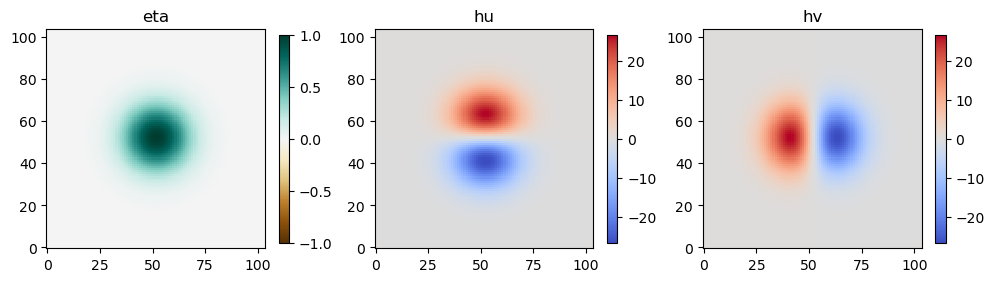

In [3]:
# Define a small domain 
nx, ny = 100, 100
dx, dy = 10, 10

# Required gravitational constant and Coriolis parameter (only for initial conditions)
g = 9.81
f = 1e-2    


# The GPU Ocean model runs a finite-volume simulator on a non-staggered grid.
# Here, the physical variables are defined in cell centeres representing average values within each cell.
# The updated solution within each cell depends on the cell values from two cells in each direction.
# For efficiency, we apply the same numerical stencil at each cell within the domain. 
# This requires that the domain is padded with two ghost cells in each direction, and the arrays holding eta, hu and hv are therefore of size:
ghost_cells = 2
dataShape = (ny + ghost_cells*2, ny + ghost_cells*2)
all_ghost_cells = [ghost_cells]*4

# Define variables and obtain initial conditions
eta = np.zeros(dataShape, dtype=np.float32)
hu  = np.zeros(dataShape, dtype=np.float32)
hv  = np.zeros(dataShape, dtype=np.float32)

# Constant equilibrium depth - Hm at cell centeres, Hi at cell intersections
eq_depth = 5.0
Hm = np.ones(dataShape, dtype=np.float32)*eq_depth
Hi = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*eq_depth

# Initialize eta, hu and hv accoding to a (approximate) geostrophical balanced rotating bump
BathymetryAndICs.initializeBalancedBumpOverPoint(eta, hu, hv, 
                                                nx, ny, dx, dy, all_ghost_cells,
                                                0.5, 0.5, # relative placement of bump in x and y
                                                1.0, 5, # bump height and relative width
                                                f, eq_depth, g)

# Plot the ocean state
reload(PlotHelper)
PlotHelper.imshow3(eta, hu, hv)

u = hu/(eta + Hm)
v = hv/(eta + Hm)
max_vel = np.max(np.sqrt(u**2 + v**2))
print("Max velocity: " + str(max_vel))

# Define periodic boundary conditions (type 1 is wall, type 2 is periodic, type 3 is open and requires boundary condition data)
boundary_conditions = Common.BoundaryConditions(2,2,2,2) 


In [4]:
# Make a simulator object so that eta, hu, hv and Hm are uploaded to the GPU
sim = GPUOceanSim.GPUOceanSim(gpu_ctx, eta, hu, hv, Hi, nx, ny, dx, dy, 0.0, g, f, 0, boundary_conditions=boundary_conditions)

96600


Text(0.5, 1.0, 'initial positions')

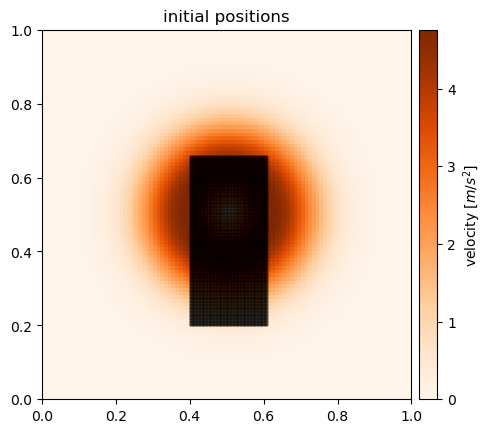

In [5]:
# Initialize drifters regularly in the following ranges
x_positions = np.arange(40*dx, (60+1)*dx, 1)
y_positions = np.arange(20*dy, (65+1)*dy, 1)

num_drifters = len(x_positions)*len(y_positions)
print(num_drifters)
init_positions = np.zeros((num_drifters, 2))
d = 0
for x in x_positions:
    for y in y_positions:
        init_positions[d, 0] = x
        init_positions[d, 1] = y
        d = d+1        

# Plot the drifter positions on top of the velocity map of the ocean state
ax = DrifterPlotHelper.background_from_sim(sim)
DrifterPlotHelper.add_drifter_positions_on_background(ax, init_positions, s=0.01, alpha=0.4)
ax.set_title("initial positions")

In [9]:
class SimpleDrifters:
    """
    As simple as possible class for drifters using PyCUDA and GPU Ocean.
    
    To support interoperability, the API should eventually be similar to the GPUDrifterCollection class.
    At the same time, it should be mentioned that there are a lot of functions there that are never used...
    """

    def __init__(self, gpu_ctx, drifter_positions):

        assert(drifter_positions.shape[1] == 2), "expecting drifter_positions to be of shape (N, 2)"
        self.num_drifters = drifter_positions.shape[0]

        # GPU stuff
        self.gpu_ctx = gpu_ctx
        self.gpu_stream = cuda.Stream() # Different streams can in principle be run in parallel

        # Define how we want to distribute the work on the GPU
        # Here, we assume that each thread is responsible for moving one drifter
        # Local size refers to the number of threads in each block (organized in 3D)
        # global size refers to the number of blocks that will be run on the GPU (can be organized in 2D or 3D)
        self.block_width = 32 
        self.block_height = 1

        self.local_size = (self.block_width, self.block_height, 1)
        self.global_size = (int(np.ceil((self.num_drifters + 1)/float(self.block_width))), 1)
        

        # Allocate GPU memory and intialize using the 2D Array utility function, which is a wrapper around pycuda.gpuarray
        # Data size parameters are given by the signature (_, nx, ny, ghost_cells_x, ghost_cells_y, _)
        self.drifter_positions_device = Common.CUDAArray2D(self.gpu_stream, 
                                                           2, self.num_drifters, 0, 0,
                                                           drifter_positions)
        
        # Compile cuda file
        self.drift_kernels = gpu_ctx.get_kernel("super_simple_drift_kernel.cu", \
                                                defines={'block_width': self.block_width, 'block_height': self.block_height
                                                       })

        # Get CUDA functions and define data types for prepared_{async_}call()
        self.superSimpleDriftKernel = self.drift_kernels.get_function("superSimpleDrift")
        self.superSimpleDriftKernel.prepare("iifffPiPiPiPiiPi")
        # The input string to prepare defines the data type for each input parameter in order
        # Example: prepare("ifPi") means that the kernel parameters have type signature (int, float, pointer, int)


    def getDrifterPositions(self):
        # Download the positions from the gpu (device) to the host (cpu)
        return self.drifter_positions_device.download(self.gpu_stream)

    def setDrifterPositions(self, drifter_positions):
        # Upload new positions from the cpu (host) to the device (gpu)
        assert(drifter_positions.shape == (self.num_drifters, 2)), "expecting drifter_positions of shape "+str((self.num_drifters, 2))+" but got "+str(drifter_positions.shape)
        self.drifter_positions_device.upload(self.gpu_stream, drifter_positions)

    def drift(self, sim, dt):
        # Call the kernel to simulate the drifters for dt seconds using the ocean state available in the sim
        # Note: Only pointers to GPU memory can be given to the cuda kernel function

        # Disclaimer:The gpu arrays for the simulator has does not have the correct names for historical reasons...
        # The values for eta are called h
        # The values for Hm are called Bm
        # Sorry...
        # Furthermore, the simulator has two buffers for each variable (e.g., hu0 and hu1), 
        # where the *0 is the one you should use, and *1 is used as a temporary storage during two-stage Runge Kutta for the finite volume method

        # The first three parameters to the kernel is always the subdivision of work (globale size and local size), and the gpu stream that will execute the kernel
        self.superSimpleDriftKernel.prepared_async_call(self.global_size, self.local_size, self.gpu_stream,
                                               sim.nx, sim.ny, sim.dx, sim.dy, np.float32(dt),
                                               sim.gpu_data.h0.data.gpudata, sim.gpu_data.h0.pitch,
                                               sim.gpu_data.hu0.data.gpudata, sim.gpu_data.hu0.pitch,
                                               sim.gpu_data.hv0.data.gpudata, sim.gpu_data.hv0.pitch,
                                               sim.bathymetry.Bm.data.gpudata, sim.bathymetry.Bm.pitch,
                                               np.int32(self.num_drifters),
                                               self.drifter_positions_device.data.gpudata,
                                               self.drifter_positions_device.pitch )
        


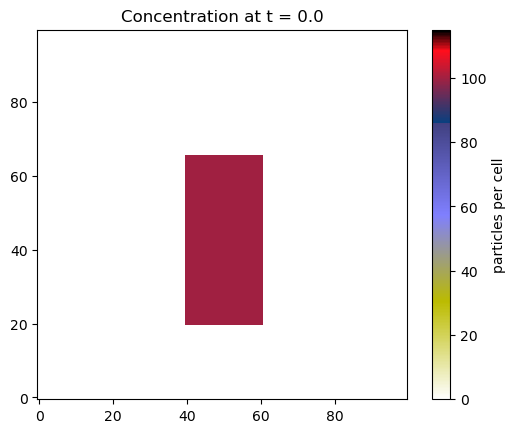

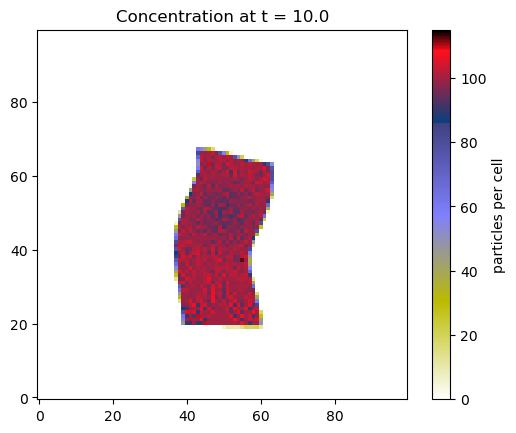

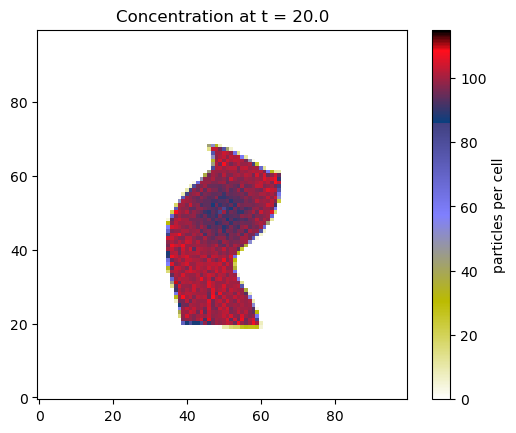

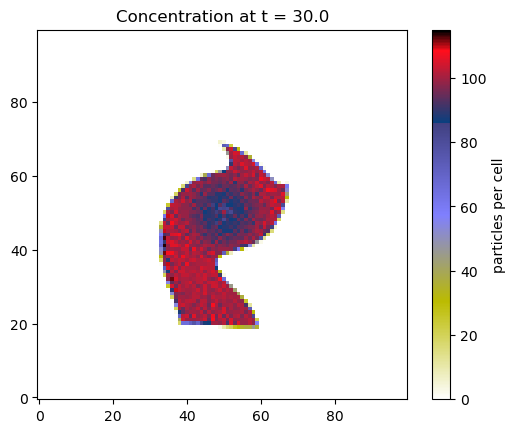

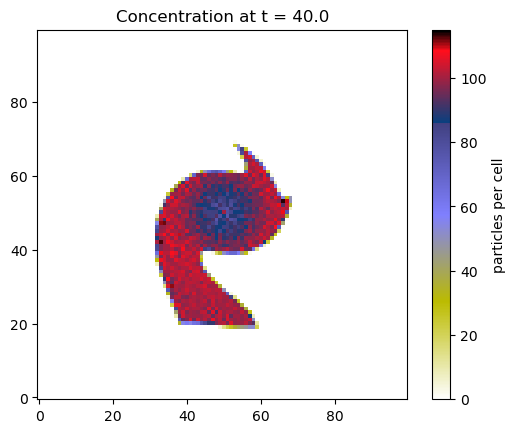

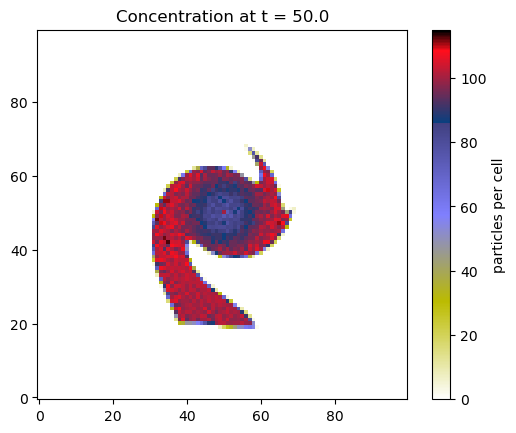

In [7]:
# Define drifter object 
drifters = SimpleDrifters(gpu_ctx, init_positions)

# Define two plotting functions to choose from
def plotAsParticles(sim, drifters, t):
    ax = DrifterPlotHelper.background_from_sim(sim)
    DrifterPlotHelper.add_drifter_positions_on_background(ax, drifters.getDrifterPositions(), s=0.01, alpha=0.4)
    ax.set_title("At t = "+str(t)) 

def plotAsConcentration(sim, drifters, t):
    # Mapping the Lagrangian particles to a concentration field
    c = LagrangianUtils.lagrangian2concentration(drifters.getDrifterPositions(), 
                                                 sim.nx, sim.ny, sim.dx, sim.dy, 
                                                 total_concentration=drifters.num_drifters)
    fig = plt.figure()
    plt.imshow(c, origin='lower', cmap=plt.cm.gist_stern_r, vmax=115)
    cb = plt.colorbar()
    cb.set_label("particles per cell")
    plt.title("Concentration at t = "+str(t))

# Check that inital conditions look as expected
#plotAsParticles(sim, drifters, 0.0)
plotAsConcentration(sim, drifters, 0.0)

# Simulate drift 
dt = 1.0
T_end = 50
t = 0
plot_t = list(range(10, T_end+1, 10))
while t < T_end:
    drifters.drift(sim, dt)
    t += dt
    if t in plot_t:
        #plotAsParticles(sim, drifters, t)
        plotAsConcentration(sim, drifters, t)